In [1]:
import ramanspy as rp
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.signal import find_peaks
import pysptools.abundance_maps.amaps as amaps
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

In [2]:
# pip install scipy==1.12.0

In [5]:
## To import 2D or 3D Raman maps
map_type='3D'
pattern_3D="FG19-101-C-50X-TL-3D_49mw--Scan LA--*--Spec.Data 1.mat" ## This is if doing 3D, the asterisk should be for whatever the layer number is (the only unrepeated part of the filenames)
slice_key_2D='XY' ## If doing 2D select the slice you want to look at

data_folder = os.getcwd() #Change this to wherever the layers are stored, or just put the notebook in the folder.

if map_type=='2D':
    mat_files = glob.glob(os.path.join(data_folder, '*.mat'))
    if not mat_files:
        print("Error: No files found. Check folder path and file format")
    else:
        selected_slice= [k for k in mat_files if slice_key_2D in k][0]
        map_2D=rp.load.witec(selected_slice)
        print(map_type+" Mode")
        print(selected_slice)
        print('Loaded '+slice_key_2D+ ' map')

elif map_type=='3D':
    file_pattern = os.path.join(data_folder, pattern_3D)
    image_layer_files = sorted(glob.glob(file_pattern))
    print(map_type+" Mode")
    for file_path in image_layer_files:
        print(file_path)
    if not image_layer_files:
        print("Error: No files found. Check folder path and pattern")
    else:
        raman_image_stack = [rp.load.witec(image_layer_file) for image_layer_file in image_layer_files]
        volume = rp.SpectralVolume.from_image_stack(raman_image_stack)
        print("Spectral Volume created")

3D Mode
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--019--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--020--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--021--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--022--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--023--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--024--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--025--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL

## Step 2. Preprocess the whole raman object (baseline, despike, denoise, normalize)

In [7]:
if map_type=='2D':
    raman_object=map_2D
elif map_type=='3D':
    raman_object=volume
else:
    print("Error: check map_type")

########Preprocess the whole raman_object
preprocessing_pipeline_1800g = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(kernel_size=1),
    rp.preprocessing.denoise.SavGol(window_length=4, polyorder=3),
    rp.preprocessing.baseline.ASLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=False),
])
preprocessing_pipeline_300g = rp.preprocessing.Pipeline([
    rp.preprocessing.denoise.SavGol(window_length=4, polyorder=3),
    rp.preprocessing.baseline.ASLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=False),
])
#rp.preprocessing.despike.WhitakerHayes()
preprocessed_raman_object = preprocessing_pipeline_300g.apply(raman_object)
preprocessed_raman_object.shape

(10, 10, 10)

### View the results of the pre-processing and look at individual spectra

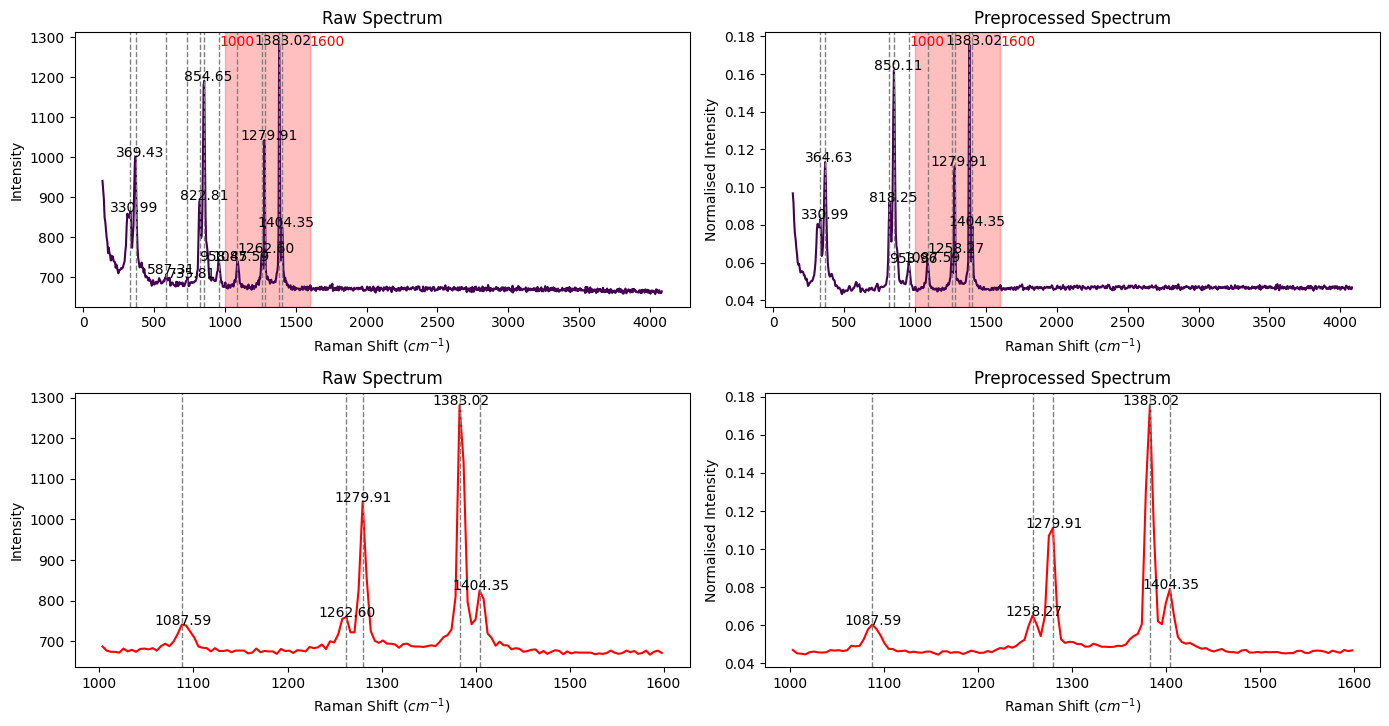

In [8]:
############ Pick spectrum indices to plot in two dimensions (applies to 2D and 3D) ###############
selected_spectrum_2Dindex = (5, 5)

############ For 3D, pick image layer, it will turn 2D index and layer to 3D spectrum index ###############
selected_image_layer = 5
selected_spectrum_3Dindex = (selected_spectrum_2Dindex[0],selected_spectrum_2Dindex[1], selected_image_layer)

############ Crop size for the zoom in spectra at bottom ################
x1=1000#1275
x2=1600#1293

############ Peak prominence plotting filter ############################
raw_prom_filter=20
pp_prom_filter=0.01

##########################
if map_type=='2D':
    selected_spectrum_index=selected_spectrum_2Dindex
elif map_type=='3D':
    selected_spectrum_index=selected_spectrum_3Dindex
else:
    print("Error: check map_type")

#### Create the figure#######################
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

#### First plot the whole spectra in the top two subplots
rp.plot.spectra(raman_object[selected_spectrum_index],ax=axs[0,0], title="Raw Spectrum")
axs[0,0].set_ylabel("Intensity")
axs[0,0].set_xlabel("Raman Shift ($cm^{-1}$)")

rp.plot.spectra(preprocessed_raman_object[selected_spectrum_index], ax=axs[0,1], title="Preprocessed Spectrum")
axs[0,1].set_ylabel("Normalised Intensity")
axs[0,1].set_xlabel("Raman Shift ($cm^{-1}$)")


## FInd the peaks and plot them on the two subplots on top
## There is a ramanspy function but it always plots the labels wrong, it's not easy to manipulate the position of the peak labels.
def plot_peaks(spectral_data, spectral_axis, prominence, ax,peak_label_pos=1):
    peak_indices, _ = find_peaks(spectral_data, prominence=prominence)
    peak_wavenumbers = spectral_axis[peak_indices]
    peak_intensities = spectral_data[peak_indices]
    for wavenumber, intensity in zip(peak_wavenumbers, peak_intensities):
        ax.axvline(x=wavenumber, color='gray', linestyle='--', linewidth=1)
        ax.text(wavenumber + peak_label_pos, intensity, f'{wavenumber:.2f}', ha='center')
    return peak_wavenumbers, peak_intensities

processed_peaks = plot_peaks(preprocessed_raman_object[selected_spectrum_index].spectral_data, preprocessed_raman_object[selected_spectrum_index].spectral_axis, pp_prom_filter, axs[0,1],peak_label_pos=30)
raw_peaks = plot_peaks(raman_object[selected_spectrum_index].spectral_data, raman_object[selected_spectrum_index].spectral_axis, raw_prom_filter, axs[0,0],peak_label_pos=30)

## To show a specific range in color
color='red'

axs[0,0].axvspan(x1, x2, alpha=0.25, color=color, zorder=0)
axs[0,0].text(x1-40, .95, x1, transform=axs[0,0].get_xaxis_transform(),color=color)
axs[0,0].text(x2, .95, x2, transform=axs[0,0].get_xaxis_transform(),color=color)

axs[0,1].axvspan(x1, x2, alpha=0.25, color='red', zorder=0)
axs[0,1].text(x1-40, .95, x1, transform=axs[0,1].get_xaxis_transform(),color=color)
axs[0,1].text(x2, .95, x2, transform=axs[0,1].get_xaxis_transform(),color=color)


################ Now display the cropped regions in the two bottom plots
cropped_raw = rp.preprocessing.misc.Cropper(region=(x1, x2)).apply(raman_object[selected_spectrum_index])
cropped_preprocessed = rp.preprocessing.misc.Cropper(region=(x1, x2)).apply(preprocessed_raman_object[selected_spectrum_index])

rp.plot.spectra(cropped_raw, ax=axs[1,0], title="Raw Spectrum",color=color)
axs[1,0].set_ylabel("Intensity")
axs[1,0].set_xlabel("Raman Shift ($cm^{-1}$)")

rp.plot.spectra(cropped_preprocessed, ax=axs[1,1], title="Preprocessed Spectrum",color=color)
axs[1,1].set_ylabel("Normalised Intensity")
axs[1,1].set_xlabel("Raman Shift ($cm^{-1}$)")
# ## Plot the peaks
plot_peaks(cropped_raw.spectral_data, cropped_raw.spectral_axis, raw_prom_filter, axs[1,0])
plot_peaks(cropped_preprocessed.spectral_data, cropped_preprocessed.spectral_axis, pp_prom_filter, axs[1,1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## This calculates abundance map if you can feed pure spectra (instead of auto demix)

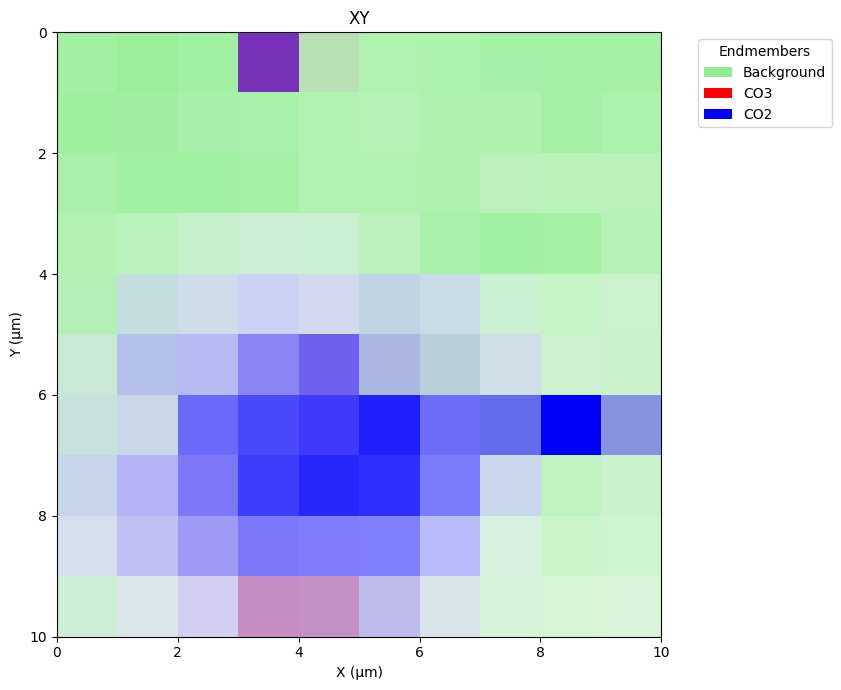

In [9]:
micronperpixel=1 ## set this to whatever your scale is (from metadata) 
endmember1 = rp.load.witec("CO2_only_endmember.mat")
endmember2 = rp.load.witec("CO3_only_endmember.mat")
endmember3 = rp.load.witec("olivine_endmember.mat")


known_endmembers = [endmember1, endmember2, endmember3]
preprocessed_endmembers=[ preprocessing_pipeline_300g.apply(n) for n in known_endmembers]
endmembers=np.array([n.spectral_data for n in preprocessed_endmembers]) #list of endmember arrays

spatial_shape = preprocessed_raman_object.shape 
map_data_2d = preprocessed_raman_object.spectral_data.reshape(-1, preprocessed_raman_object.spectral_data.shape[-1])

abundances = amaps.NNLS(M=map_data_2d, U=endmembers)
abundance_maps = abundances.reshape(spatial_shape[0], spatial_shape[1], -1)

selected_indices = [0, 1,2]
labels_ = ['0', '1','2']

selected_endmembers = [endmembers[i] for i in selected_indices]
selected_abundances = [abundance_maps[i] for i in selected_indices]

selected_indices = [2,1,0]
endmember_names = ['CO2','CO3','Background']
labels_ = [endmember_names[i] for i in selected_indices]

fig, ax = plt.subplots(figsize=(8, 7)) # Adjust figure size as needed
base_colors = ['lightgreen', 'red', 'blue'] # Example colors for your 3 endmembers
white = [1, 1, 1, 0]

pixel_height, pixel_width = abundance_maps.shape[0], abundance_maps.shape[1]
micron_width = pixel_width / micronperpixel
micron_height = pixel_height / micronperpixel

# Define the extent for imshow: [left, right, bottom, top]
# Since origin='upper', y-axis goes from top (0) to bottom (max_height)
# So, bottom will be micron_height and top will be 0 for the extent.
image_extent = [0, micron_width, micron_height, 0] # [xmin, xmax, ymin, ymax] for origin='upper'

for i, original_endmember_index in enumerate(selected_indices):
    current_abundance_map = abundance_maps[:, :, original_endmember_index]

    ax.imshow(current_abundance_map, cmap=LinearSegmentedColormap.from_list('', [white, base_colors[i]]), origin='upper',
            vmin=current_abundance_map.min(), vmax=current_abundance_map.max(),
            extent=image_extent) # Apply the calculated extent
    
ax.set_title(slice_key_2D)
ax.set_xlabel('X (µm)') # Changed label
ax.set_ylabel('Y (µm)') # Changed label
ax.set_aspect('equal') # Keep aspect ratio equal

legend_elements = [Patch(facecolor=base_colors[j], label=labels_[j])
                   for j in range(len(selected_indices))]
ax.legend(handles=legend_elements, title="Endmembers", loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()
fig.savefig(f"{slice_key_2D}slice_101C_combinedabundance.png")





TypeError: Invalid shape (10, 10, 10) for image data

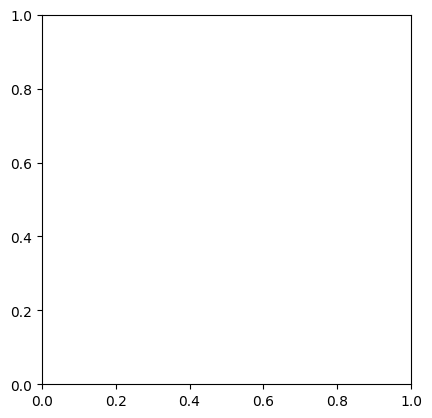

In [10]:
#### This will also be used to show the maps later
bands = [1090, 1280, 1390]
band_components = ['carbonate', 'co2v1', 'co2v2','background']
labels = [f'{slice_key_2D}{' '}{comp}\n{band} cm$^{{{-1}}}$' for band, comp in zip(bands, band_components)]

ax=rp.plot.image([preprocessed_raman_object.band(band) for band in bands], title=labels, xlabel='X',ylabel='Z')

for i, ax in enumerate(ax):
    # Create a new figure for each subplot to save it individually
    fig = ax.figure
    fig.savefig(f"{slice_key_2D}slice_101C_band_{bands[i]}_{band_components[i]}.png")
    # plt.close(fig) # Close the figure to free up memory

## This is using the autodetect demixing, but it struggles with the 300g

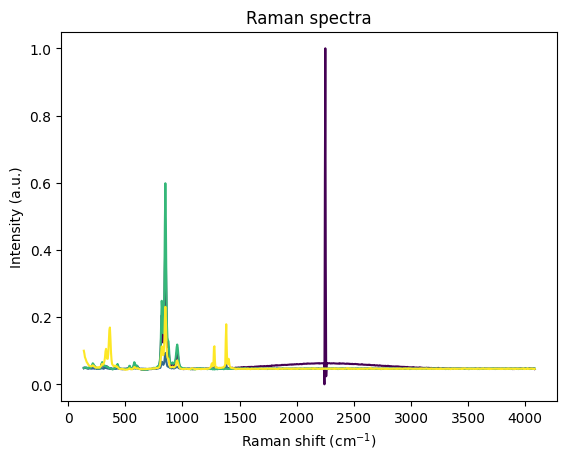

In [11]:
###### This would be to find components, but it's not working well for the 300g spectra. Maybe they are just too mixed. 

nfindr = rp.analysis.unmix.NFINDR(n_endmembers=4)
vca = rp.analysis.unmix.VCA(n_endmembers=4)

abundance_maps, endmembers = nfindr.apply(preprocessed_raman_object)

ax = rp.plot.spectra(endmembers, wavenumber_axis=preprocessed_raman_object.spectral_axis, plot_type='single')

selected_indices = [0,1,2,3]
labels_ = ['0','1','2','3']

selected_endmembers = [endmembers[i] for i in selected_indices]
selected_abundances = [abundance_maps[i] for i in selected_indices]


TypeError: Invalid shape (10, 10, 10) for image data

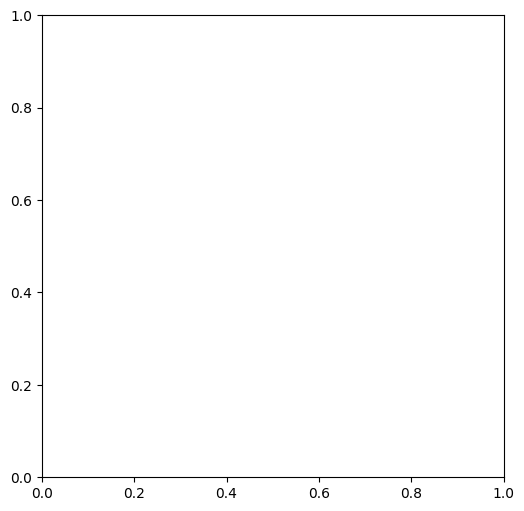

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import io
from PIL import Image


selected_image_layer = 0

fig, ax = plt.subplots(figsize=(8, 6))

cmap=plt.colormaps.get_cmap('viridis')(np.linspace(0, 1, len(selected_abundances))) #based on viridis, this is the default
# cmap=[(0, 0, 1, 1), (0.7, 0.7, 0.7, 1)] # Custom colors

white=(1,1,1,0)

order = ['0','1','2','3'] # Define the order of plotting 'Background'
cmap_dict = {}

for label in order:
    i = labels_.index(label)
    cmap_i=LinearSegmentedColormap.from_list('', [white, cmap[i]])
    cmap_dict[label] = cmap_i
    ax.imshow(selected_abundances[i], cmap=cmap_i)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_i, norm=mcolors.Normalize(vmin=0, vmax=1)), ax=ax, orientation='vertical', label=label, shrink=0.7, pad=0.1)

ax.set_title(f'Combined Abundance Map - Layer {selected_image_layer}')
ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.tight_layout()
plt.show()

# # New: Render figure to buffer and save as image
# fig.canvas.draw()
# rgba_buffer = fig.canvas.buffer_rgba() # Fix: Use buffer_rgba() instead of tostring_rgba()
# width, height = fig.canvas.get_width_height()
# image_array = np.asarray(rgba_buffer) # np.asarray() can directly handle memoryview
# img_pil = Image.fromarray(image_array)
# output_filename = 'combined_abundance_map.bmp'
# img_pil.save(output_filename)

## For plotting volumes 

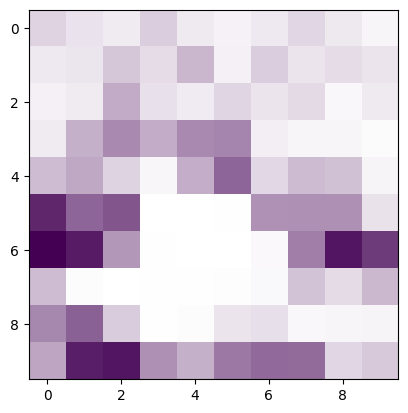

In [ ]:
bands = [850,1090, 1280, 1390]
band_components = ['carbonate', 'co2v1', 'co2v2','background']
labels = [f'{slice_key_2D}{' '}{comp}\n{band} cm$^{{{-1}}}$' for band, comp in zip(bands, band_components)]

## For volumes layer export without anything
selected_image_layer = 5
plt.imshow(selected_abundances[0][..., selected_image_layer], cmap=LinearSegmentedColormap.from_list('', [white, cmap[0]]))
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig(f"Layer {selected_image_layer}", bbox_inches = 'tight', pad_inches = 0)
plt.show()

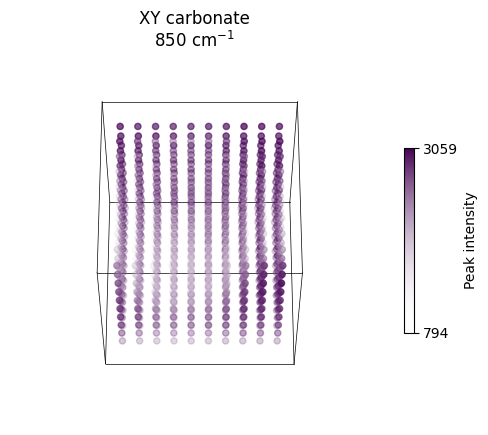

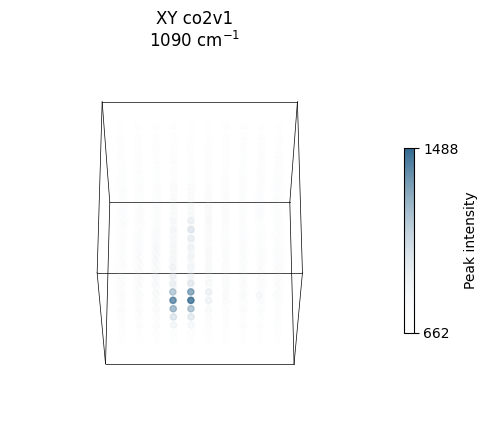

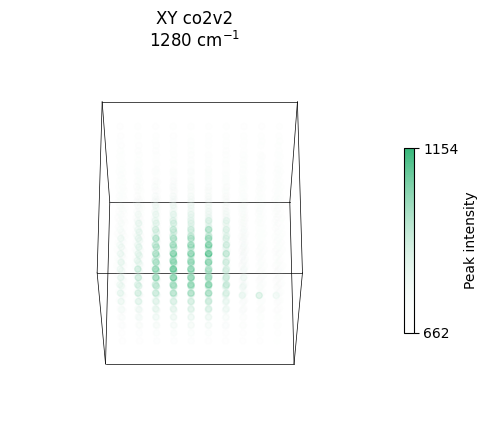

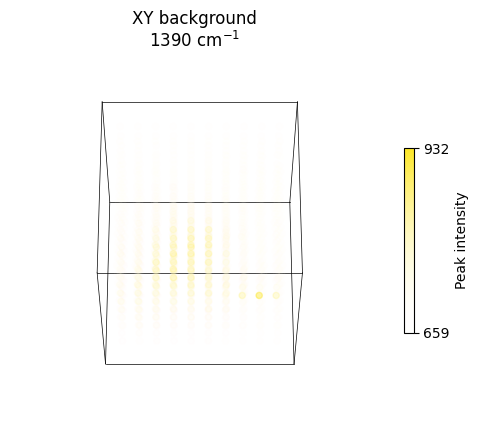

In [16]:
axs = rp.plot.volume([volume.band(band) for band in bands], title=labels)

## Calculate CO2 captured in carbonates by mass balance

In [ ]:
def calc_vol(d1,d2,d3=None,method='average',shape='ellipsoid'):
    if shape == 'ellipsoid':
        if method == 'average':
            vol = (4/3)*np.pi*(d1/2)*(d2/2)*(((d1/2)+(d2/2))/2)
        elif method == 'measured':
            vol = (4/3)*np.pi*(d1/2)*(d2/2)*(d3/2)
        elif method == 'minimum':
            vol = (4/3)*np.pi*(d1/2)*(d2/2)*((np.nanmin([d1,d2])/2))

    elif shape == 'rect.paral':
        if method == 'average':
            vol = d1*d2*((d1+d2)/2)
        elif method == 'measured':
            vol = d1*d2*d3
        elif method == 'minimum':
            vol = d1*d2*np.nanmin([d1,d2])
        else: 
            print("Error: check method")
    else:
        print("Error: check shape")

    return vol


FI_101C_d1=8.9*10**-4
FI_101C_d2=7.7*10**-4

FI_101A_d1=5.5*10**-4
FI_101A_d2=4.9*10**-4
FI_101A_vol=calc_vol(d1=FI_101A_d1,d2=FI_101A_d2,method='average',shape='ellipsoid')

#maximum dimensions of carbonate
CaCO3_d1=1.5*10**-4
CaCO3_d2=2.5*10**-4
CaCO3_d3=6*10**-4

cavity_101C_vol_total=calc_vol(d1=FI_101C_d1,d2=FI_101C_d2,method='average',shape='ellipsoid') ## Volume of the FI cavity (without substracting CO3)
carb_101C_vol=calc_vol(d1=CaCO3_d1,d2=CaCO3_d2,d3=CaCO3_d3,method='measured',shape='rect.paral') ## Volume of the carbonate phase

FI_101C_vol=cavity_101C_vol_total-carb_101C_vol

vol_percent_carb=(carb_101C_vol*100)/cavity_101C_vol_total
CO2_volpercent=100-vol_percent_carb

CaCO3_rho=2.8
CO2_fluid_rho=0.925

mass_CO2_fluid=CO2_fluid_rho*FI_101C_vol
mass_CaCO3=CaCO3_rho*carb_101C_vol

molarmass_Ca=40.08
molarmass_C=12.01
molamass_O=16.00
molarmass_CaCO3=molarmass_Ca+molarmass_C+3*molamass_O
molarmass_CaO=molarmass_Ca+molamass_O
molarmass_CO2=molarmass_C+2*molamass_O

CaCO3_mol=mass_CaCO3/molarmass_CaCO3
CO2_mol=CaCO3_mol

mass_CO2=CO2_mol*molarmass_CO2
print(100*mass_CO2/(mass_CO2+mass_CO2_fluid))
print((mass_CO2_fluid+mass_CO2)/cavity_101C_vol_total)

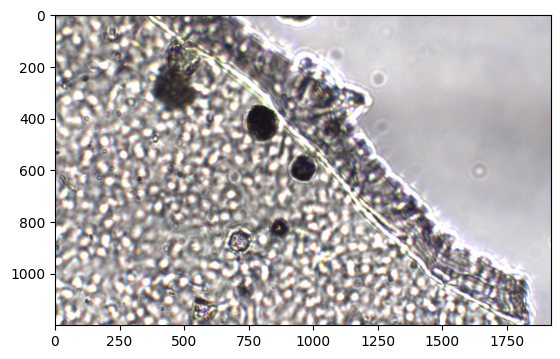

In [44]:
bmp_image_path = "P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Fi_standards\Polishing_series_062025\Polishseries_062425\Maps\B23_FI5_1_50X_premap.bmp" 
img = Image.open(bmp_image_path)
# Convert image to a NumPy array for plotting
img_array = np.array(img)

# If your BMP has an alpha channel (transparency), you might want to use it.
# Otherwise, simply plotting it will overlay it.
# Since you said the size is the same, matplotlib will overlay them correctly.
plt.imshow(img_array)


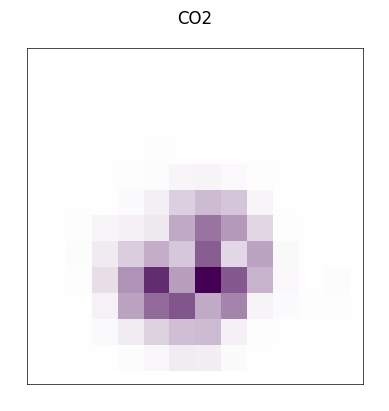

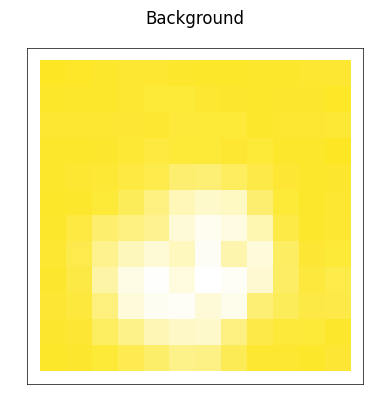

In [146]:
axs = rp.plot.image([abundance_map[..., selected_image_layer] for abundance_map in selected_abundances], title=labels_, cbar=False)

C:\Users\charl\AppData\Local\Temp\ipykernel_34804\3527601650.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap()(np.linspace(0, 1, len(selected_abundances)))


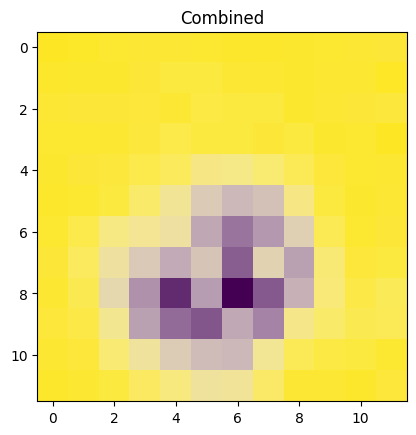

In [145]:
selected_image_layer=5
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap()(np.linspace(0, 1, len(selected_abundances)))

white = [1, 1, 1, 0]

order = ['Background', 'CO2']
for label in order:
    i = labels_.index(label)
    ax.imshow(selected_abundances[i][..., selected_image_layer], cmap=LinearSegmentedColormap.from_list('', [white, cmap[i]]))

ax.set_title('Combined')

plt.show()